# Explain the prediction of VespaG using other approaches using the PLA2 Dataset   

For statistical approaches we need large volumes of data to increase the statistical strength of the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os

import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder
from src.plotting import *
from src.amino_acid_groups import AA_GROUPS
from src.constants import GEMME_ALPHABET
from src.utils import *

## Load VespaG results for the PLA2 Dataset and enrich with further features

In [3]:
# load all the vespag scores for the pla2 dataset 
vespag_folder = '/mnt/f/nicole/pla2_vespag'
vespag_scores = load_vespag_scores_from_folder(vespag_folder)   
# invert the vespag score to get the mutation effect
vespag_scores['mutation_effect'] = - vespag_scores['vespag']
# normalize the mutation effect into [0,1]
vespag_scores['mutation_effect_normalized'] = (vespag_scores['mutation_effect'] - vespag_scores['mutation_effect'].min()) / (vespag_scores['mutation_effect'].max() - vespag_scores['mutation_effect'].min())
# extract residue_index 
vespag_scores['residue_index'] = vespag_scores['residue'].str[1:].astype(int)
# extract the wildtype residue
vespag_scores['wildtype'] = vespag_scores['residue'].str[0]
# extract the mutant residue
vespag_scores['mutant'] = vespag_scores['mutation'].str[-1]
# add the amino acid annotation for each wildtype
aa_groups = list(AA_GROUPS.keys())
for aa_group in aa_groups:
    vespag_scores[f'wildtype_{aa_group}'] = vespag_scores['wildtype'].apply(lambda x: AA_GROUPS[aa_group][x])
    vespag_scores[f'mutant_{aa_group}'] = vespag_scores['mutant'].apply(lambda x: AA_GROUPS[aa_group][x])
    vespag_scores[f'change_{aa_group}'] = vespag_scores[f'wildtype_{aa_group}'] != vespag_scores[f'mutant_{aa_group}']
vespag_scores.head()

Loading VespaG scores: 100%|██████████| 524/524 [00:13<00:00, 39.94file/s]


,residue,mutation,vespag,id,mutation_effect,mutation_effect_normalized,residue_index,wildtype,mutant,wildtype_hydropathy_classes,...,change_physicochemical_classes,wildtype_charge_classes,mutant_charge_classes,change_charge_classes,wildtype_polarity_classes,mutant_polarity_classes,change_polarity_classes,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,change_hydrogen_donor_acceptor_classes
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,2.552438,0.364656,1,N,A,hydrophilic,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,3.675682,0.493063,1,N,Y,hydrophilic,...,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,4.004534,0.530656,1,N,W,hydrophilic,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,donor,True
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,3.488040,0.471612,1,N,V,hydrophilic,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,2.369666,0.343762,1,N,T,hydrophilic,...,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False


In [4]:
aa_properties = [col for col in vespag_scores.columns if '_classes' in col]
print(aa_properties)

['wildtype_hydropathy_classes', 'mutant_hydropathy_classes', 'change_hydropathy_classes', 'wildtype_volume_classes', 'mutant_volume_classes', 'change_volume_classes', 'wildtype_chemical_classes', 'mutant_chemical_classes', 'change_chemical_classes', 'wildtype_physicochemical_classes', 'mutant_physicochemical_classes', 'change_physicochemical_classes', 'wildtype_charge_classes', 'mutant_charge_classes', 'change_charge_classes', 'wildtype_polarity_classes', 'mutant_polarity_classes', 'change_polarity_classes', 'wildtype_hydrogen_donor_acceptor_classes', 'mutant_hydrogen_donor_acceptor_classes', 'change_hydrogen_donor_acceptor_classes']


## Check distribution of mutational effect

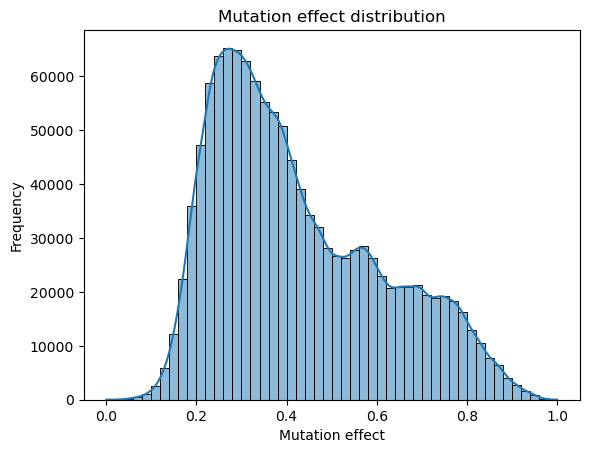

In [5]:
# check whether the mutational effect is normally distributed 
sns.histplot(vespag_scores['mutation_effect_normalized'], bins=50, kde=True)
plt.xlabel('Mutation effect')
plt.ylabel('Frequency')
plt.title('Mutation effect distribution')
plt.show()

## Feature Correlation Analysis

- Compute correlation between each amino acid properties and the mutation effect
- Since the amino acid properties are categorical variables and we the mutational effect is not nomrally distributed, we will use the Kruskal-Wallis test.
- H0 is, that there is no difference in the medial of the groups

In [6]:
from scipy.stats import kruskal
from scipy.stats import chi2

alpha = 0.05

# perform kruskal wallis test between each amino acid property and the mutation effect
kruskal_results = {}
for aa_property in aa_properties:
    aa_property_values = vespag_scores[aa_property].unique()
    groups = [vespag_scores[vespag_scores[aa_property] == value]['mutation_effect_normalized'].values for value in aa_property_values]
    stat, p = kruskal(*groups)
    degrees_of_freedom = len(aa_property_values) - 1
    critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)
    kruskal_results[aa_property] = {'stat': stat, 'p': p, 'degrees_of_freedom': degrees_of_freedom, 'critical_value': critical_value, 'significant': p < alpha}

kruskal_results = pd.DataFrame(kruskal_results).T
kruskal_results = kruskal_results.sort_values('stat', ascending=False)
kruskal_results

,stat,p,degrees_of_freedom,critical_value,significant
wildtype_physicochemical_classes,300275.487193,0.0,10,18.307038,True
wildtype_chemical_classes,246171.109703,0.0,6,12.591587,True
wildtype_volume_classes,130311.346168,0.0,4,9.487729,True
wildtype_hydrogen_donor_acceptor_classes,100789.676617,0.0,3,7.814728,True
mutant_physicochemical_classes,84931.777342,0.0,10,18.307038,True
wildtype_hydropathy_classes,80681.275913,0.0,2,5.991465,True
wildtype_polarity_classes,56616.502746,0.0,1,3.841459,True
wildtype_charge_classes,52377.929532,0.0,2,5.991465,True
mutant_chemical_classes,51177.495462,0.0,6,12.591587,True
change_physicochemical_classes,47375.816948,0.0,1,3.841459,True


In [7]:
import scikit_posthocs as sp

# dunn's post hoc test for pairwise comparisons 
posthoc_results = []

for aa_property in aa_properties:
    data = vespag_scores[['mutation_effect_normalized', aa_property]].dropna()
    posthoc = sp.posthoc_dunn(data, val_col='mutation_effect_normalized', group_col=aa_property, p_adjust='bonferroni')
    
    # extract pairwise results into a list of dictionaries
    for group_1 in posthoc.index:
        for group_2 in posthoc.columns:
            if group_1 != group_2:
                posthoc_results.append({
                    'aa_property': aa_property,
                    'group_1': group_1,
                    'group_2': group_2,
                    'p_value': posthoc.loc[group_1, group_2],
                    'significant': posthoc.loc[group_1, group_2] < alpha 
                })

posthoc_results = pd.DataFrame(posthoc_results)
posthoc_results.head()

,aa_property,group_1,group_2,p_value,significant
0,wildtype_hydropathy_classes,hydrophilic,hydrophobic,0.0,True
1,wildtype_hydropathy_classes,hydrophilic,neutral,0.0,True
2,wildtype_hydropathy_classes,hydrophobic,hydrophilic,0.0,True
3,wildtype_hydropathy_classes,hydrophobic,neutral,0.0,True
4,wildtype_hydropathy_classes,neutral,hydrophilic,0.0,True


In [8]:
posthoc_results.significant.value_counts()

significant
True     400
False     10
Name: count, dtype: int64

In [9]:
posthoc_results[posthoc_results.significant]

,aa_property,group_1,group_2,p_value,significant
0,wildtype_hydropathy_classes,hydrophilic,hydrophobic,0.000000e+00,True
1,wildtype_hydropathy_classes,hydrophilic,neutral,0.000000e+00,True
2,wildtype_hydropathy_classes,hydrophobic,hydrophilic,0.000000e+00,True
3,wildtype_hydropathy_classes,hydrophobic,neutral,0.000000e+00,True
4,wildtype_hydropathy_classes,neutral,hydrophilic,0.000000e+00,True
...,...,...,...,...,...
405,mutant_hydrogen_donor_acceptor_classes,none,acceptor,0.000000e+00,True
406,mutant_hydrogen_donor_acceptor_classes,none,donor,0.000000e+00,True
407,mutant_hydrogen_donor_acceptor_classes,none,donor and acceptor,0.000000e+00,True
408,change_hydrogen_donor_acceptor_classes,False,True,2.176747e-118,True


## Conditional Mutual Information (CMI)

- To check whether model predictions depend on wildtype or mutant properties, we can use CMI, which basically tells how much knowing an amino acid property helps predict the mutation effect, given the wildtype.
- CMI quantifies how much knowing the categorical feature reduces the uncertainty of the numerical target. If the categorical variable has no effect, the mutual information will be close to zero.

Add the Input/ Outwards facing residues prediction from Getarea

In [12]:
from parse.getarea import get_getarea_data_from_folder

In [13]:
getarea_path = '/mnt/f/nicole/pla2_getarea'

getarea_df = get_getarea_data_from_folder(getarea_path)
getarea_df.head()

,residue,residue_number,total,apolar,backbone,sidechain,ratio,in_out,id
0,H1,1.0,12.62,5.83,0.09,12.52,8.1,i,AB072173_1_Protobothrops_flavoviridis
1,L2,2.0,79.70,77.11,3.05,76.65,52.4,o,AB072173_1_Protobothrops_flavoviridis
2,L3,3.0,103.26,102.91,0.55,102.71,70.3,o,AB072173_1_Protobothrops_flavoviridis
3,Q4,4.0,18.59,6.64,0.00,18.59,12.9,i,AB072173_1_Protobothrops_flavoviridis
4,F5,5.0,22.07,22.07,0.00,22.07,12.3,i,AB072173_1_Protobothrops_flavoviridis


In [19]:
vespag_scores = vespag_scores.merge(getarea_df.drop(['residue_number'], axis=1), on=['id', 'residue'])
vespag_scores.head()

,residue,mutation,vespag,id,mutation_effect,mutation_effect_normalized,residue_index,wildtype,mutant,wildtype_hydropathy_classes,...,change_polarity_classes,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,change_hydrogen_donor_acceptor_classes,total,apolar,backbone,sidechain,ratio,in_out
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,2.552438,0.364656,1,N,A,hydrophilic,...,True,donor and acceptor,none,True,21.94,4.76,0.33,21.62,18.9,i
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,3.675682,0.493063,1,N,Y,hydrophilic,...,False,donor and acceptor,donor and acceptor,False,21.94,4.76,0.33,21.62,18.9,i
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,4.004534,0.530656,1,N,W,hydrophilic,...,True,donor and acceptor,donor,True,21.94,4.76,0.33,21.62,18.9,i
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,3.488040,0.471612,1,N,V,hydrophilic,...,True,donor and acceptor,none,True,21.94,4.76,0.33,21.62,18.9,i
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,2.369666,0.343762,1,N,T,hydrophilic,...,False,donor and acceptor,donor and acceptor,False,21.94,4.76,0.33,21.62,18.9,i


In [14]:
from sklearn.feature_selection import mutual_info_regression

In [21]:
aa_properties = aa_properties + ['total', 'apolar', 'backbone', 'sidechain', 'ratio', 'in_out']

In [22]:
N_SHUFFLES = 100

# Store results
cmi_results = []

# Compute real and shuffled MI with tqdm progress bar
for aa_property in tqdm(aa_properties, desc="Calculating MI and Shuffle Control"):
    feature = vespag_scores[aa_property]
    target = vespag_scores['mutation_effect_normalized']

    # Encode categorical variable as numerical
    feature_encoded = feature.astype("category").cat.codes

    # Compute real MI
    real_mi = mutual_info_regression(feature_encoded.values.reshape(-1, 1), target, discrete_features=True)[0]

    # Compute MI for shuffled data
    shuffled_mis = []
    for _ in range(N_SHUFFLES):
        shuffled_target = np.random.permutation(target)  # Shuffle target values
        shuffled_mi = mutual_info_regression(feature_encoded.values.reshape(-1, 1), shuffled_target, discrete_features=True)[0]
        shuffled_mis.append(shuffled_mi)

    # Compute mean & std dev of shuffled MI scores
    mean_shuffled_mi = np.mean(shuffled_mis)
    std_shuffled_mi = np.std(shuffled_mis)

    # Compute Z-score
    z_score = (real_mi - mean_shuffled_mi) / (std_shuffled_mi + 1e-9)  # Avoid division by zero

    # Store results
    cmi_results.append({
        'aa_property': aa_property,
        'real_mutual_information': real_mi,
        'mean_shuffled_mi': mean_shuffled_mi,
        'std_shuffled_mi': std_shuffled_mi,
        'z_score': z_score,
        'significant': z_score > 2  # Mark significant if Z-score > 2
    })

# Convert to DataFrame
cmi_results_df = pd.DataFrame(cmi_results).sort_values('z_score', ascending=False)

Calculating MI and Shuffle Control:   0%|          | 0/27 [00:00<?, ?it/s]

Calculating MI and Shuffle Control:   0%|          | 0/27 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [50]:
cmi_results_df.sort_values('mutual_information', ascending=False).head()

,aa_property,mutual_information
9,wildtype_physicochemical_classes,0.200538
6,wildtype_chemical_classes,0.159132
10,mutant_physicochemical_classes,0.087085
3,wildtype_volume_classes,0.085689
18,wildtype_hydrogen_donor_acceptor_classes,0.075518


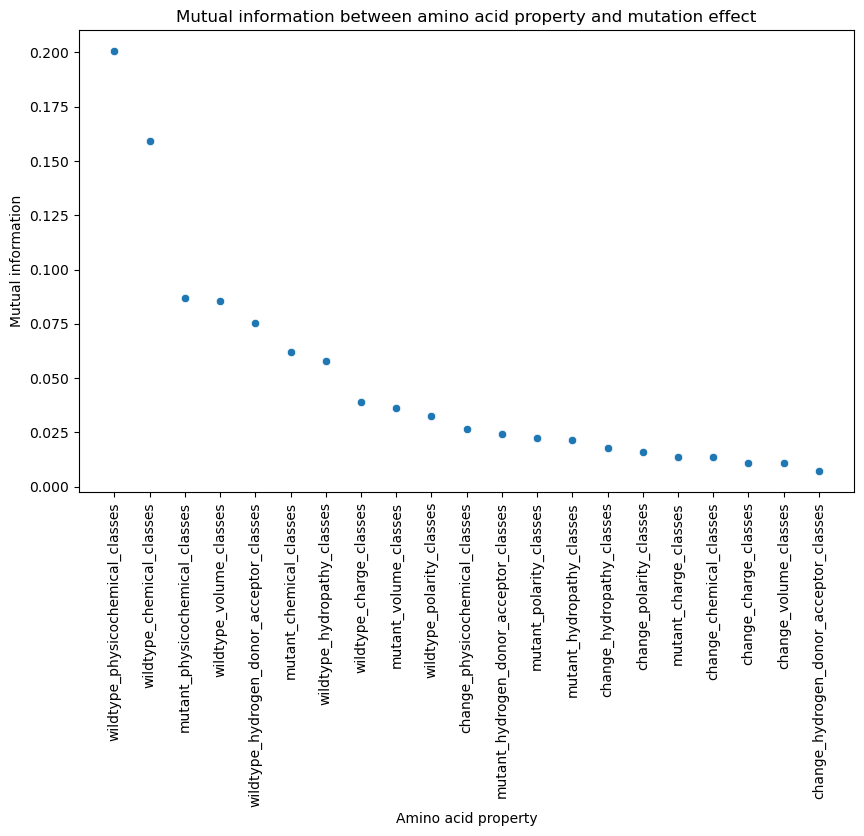

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y='mutual_information', x='aa_property', data=cmi_results_df)
plt.xlabel('Amino acid property')
plt.ylabel('Mutual information')
plt.title('Mutual information between amino acid property and mutation effect')
plt.xticks(rotation=90)
plt.show()

- SHAP to check which dimension in the embeddings influence the prediction
- Train a simple linear model to predict amino acid properties based on selected embeddings. If this works for the physiochemical classes, then we might be able to show that the model makes its predictions based on the physiochecmical classes encoded in the embeddings of the wildtype